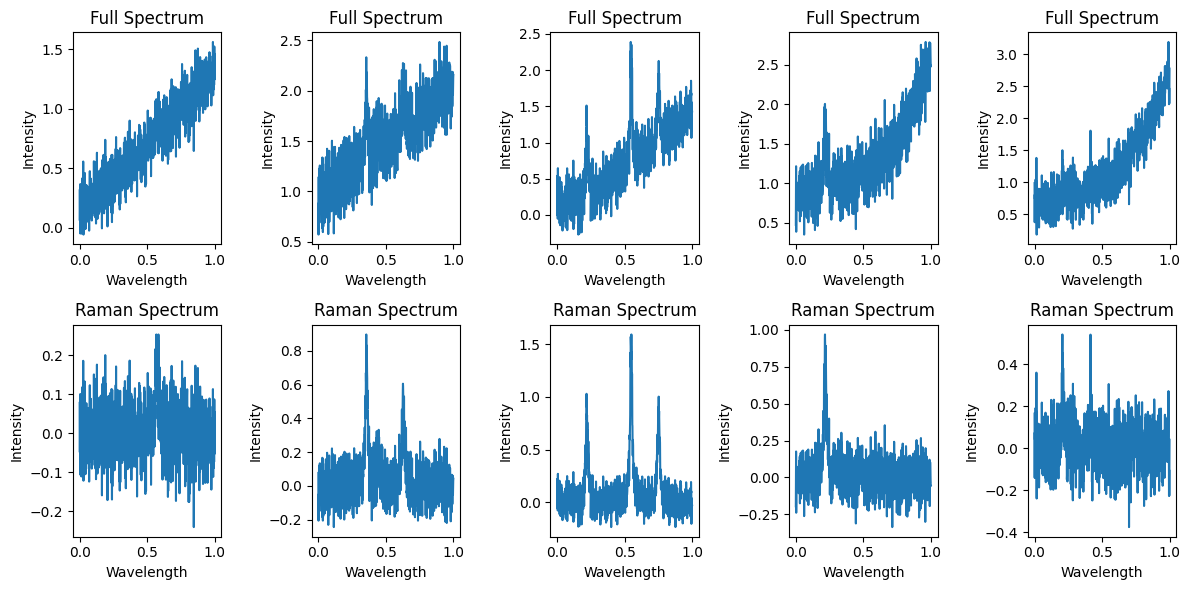

In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# 1. INPUT PARAMETERS
class SyntheticRamanSpectrum:
    def __init__(self, pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra):
        self.pixels = pixels
        self.poly_order_range = poly_order_range
        self.num_peaks_range = num_peaks_range
        self.snr_range = snr_range
        self.cosmic_ray_prob = cosmic_ray_prob
        self.num_spectra = num_spectra
        self.wavelengths = np.linspace(0, 1, self.pixels)
        self.full_spectra_list = []
        self.raman_spectra_list =  []

        for _ in range(num_spectra):
            self.generate_spectrum()

            # Add Gaussian noise
            self.add_gaussian_noise()

            # Add Chebyshev variation
            num_iterations = 10
            min_order = 1
            max_order = 5
            self.add_chebyshev_variation(num_iterations, min_order, max_order)

            # Add cosmic rays
            num_cosmic_rays = 5
            final_spectrum = self.add_cosmic_rays(num_cosmic_rays)

            # Store full synthetic spectrum
            self.full_spectra_list.append(self.noisy_spectrum)

            # Store only Raman signal
            self.raman_spectra_list.append(self.noisy_peaks)

    # Generate baseline using a polynomial
    def generate_spectrum(self):
        poly_order = np.random.randint(self.poly_order_range[0], self.poly_order_range[1] + 1)
        baseline_coefficients = np.random.rand(poly_order + 1)
        self.baseline = np.polyval(baseline_coefficients, self.wavelengths)
        
        # 2. PEAK CHARACTERISTICS
        # Generate Lorentzian Peaks
        self.peaks = np.zeros_like(self.wavelengths)
        num_peaks = np.random.randint(self.num_peaks_range[0], self.num_peaks_range[1] + 1)
        for _ in range(num_peaks):
            peak_amplitude = np.random.uniform(0, 1)
            peak_position = np.random.uniform(0.2, 0.8)
            peak_width = 1 / (self.pixels * 0.1)
            self.peaks += peak_amplitude * (peak_width ** 2) / ((self.wavelengths - peak_position) ** 2 + peak_width ** 2)
          
        # Add peaks to signal
        peaky_spectrum = self.baseline + self.peaks
    
    # 3. NOISE GENERATION
    # Generate Gaussian Noise
    def add_gaussian_noise(self, noise_amplitude_range=(0.1, 0.5)):
        # Calculate signal power
        signal_power = np.mean(np.abs(self.baseline + self.peaks) ** 2)

        # Calculate noise power based on SNR
        noise_power = signal_power / self.snr_range

        # Calculate standard deviation of noise
        noise_std = np.sqrt(noise_power)

        # Generate random noise amplitudes within specified range
        min_amp, max_amp = noise_amplitude_range
        noise_amplitudes = np.random.uniform(min_amp, max_amp)

        # Generate Gaussian noise samples
        noise = np.random.normal(0, noise_std, len(self.wavelengths))

        # Scale noise by noise amplitudes
        noise *= noise_amplitudes

        # Add noise to baseline & peaks
        self.noisy_baseline = self.baseline + noise
        self.noisy_peaks = self.peaks + noise
        self.noisy_spectrum = self.noisy_baseline + self.noisy_peaks   
        
    # 4. BASELINE VARIATION
    # Generate Chebyshev Polynomial
    def chebyshev_polynomial(self, x, *coefficients):
        order = len(coefficients)
        chebyshev_vals = np.zeros_like(x)
        
        for i in range(order):
            chebyshev_vals += coefficients[i] * np.cos(i * np.arccos(x))
         
        return chebyshev_vals

    def add_chebyshev_variation(self, num_iterations, min_order, max_order):
        # Randomly select polynomial order (for iteration)
        order = np.random.randint(min_order, max_order)

        # Initial guess for Chebyshev polynomial coefficients (randomly initialized)
        initial_guess = [np.random.uniform(-1, 1) for _ in range(order)]

        # Fit Chebyshev polynomial to noisy data (for iteration)
        popt, _ = curve_fit(self.chebyshev_polynomial, self.wavelengths, self.noisy_peaks, p0=initial_guess)

        # Generate baseline using fitted coefficients
        baseline = self.chebyshev_polynomial(self.wavelengths, *popt)

        # Add Chebyshev to noise, baseline & peaks
        chebyshev_baseline = self.noisy_baseline + baseline
        chebyshev_peaks = self.noisy_peaks + baseline
        chebyshev_noise = self.noisy_peaks + baseline

        # Add noise to chebyshev variation
        self.chebyshev_spectrum = self.noisy_spectrum + chebyshev_noise
    
    # 5. COSMIC RAYS
    # Generate Cosmic Rays
    def add_cosmic_rays(self, num_cosmic_rays):
        cosmic_rays_spectrum = self.noisy_spectrum.copy()
    
        # Calculate L2-norm of complete signal
        l2_norm = np.linalg.norm(cosmic_rays_spectrum)
    
        for _ in range(num_cosmic_rays):
            # Generate random amplitude between 0.8 & l2_norm
            cosmic_ray_amplitude = np.random.uniform(0.8, l2_norm)
        
            # Randomly select position for cosmic ray
            position = np.random.randint(0, len(cosmic_rays_spectrum))
        
            # Add cosmic ray as Lorentzian peak with width zero
            cosmic_rays_spectrum[position] += cosmic_ray_amplitude

        return cosmic_rays_spectrum

# 6. OUTPUT
# Parameters
pixels = 1024
poly_order_range = (2, 4)
num_peaks_range = (3, 5)
snr_range = 20
cosmic_ray_prob = 0.1
num_spectra = 10

synthetic_data_generator = SyntheticRamanSpectrum(pixels, poly_order_range, num_peaks_range, snr_range, cosmic_ray_prob, num_spectra)
full_spectra = synthetic_data_generator.full_spectra_list    # full_spectra contains full synthetic measured spectra
raman_spectra = synthetic_data_generator.raman_spectra_list    # raman_spectra contains only Raman signals

# Visualize results
plt.figure(figsize=(12, 6))

# Plot full synthetic spectra
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.plot(synthetic_data_generator.wavelengths, full_spectra[i])
    plt.title('Full Spectrum')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

# Plot Raman spectra
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.plot(synthetic_data_generator.wavelengths, raman_spectra[i])
    plt.title('Raman Spectrum')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')

plt.tight_layout()
plt.show()

In [2]:
# A) CALCULATE SD from SNR for ZERO-MEAN GAUSSIAN DISTRIBUTION

# A.1) Convert SNR to Linear Scale (SNR linear = 10^(SNR_target/10))

# Given SNR in dB
SNR_dB = snr_range

# Convert SNR to linear scale
SNR_linear = 10 ** (SNR_dB / 10)

print(f"SNR (linear scale): {SNR_linear}")

SNR (linear scale): 100.0


In [3]:
# A.2) Calculate Variance (V = 1/SNR linear)

# Variance using formula
variance = 1 / SNR_linear

print(f"Variance: {variance}")

Variance: 0.01


In [4]:
# A.3) Calculate Standard Deviation (σ = √Variance)
import numpy as np

# Calculate the standard deviation
std_deviation = np.sqrt(variance)

print(f"Standard Deviation: {std_deviation}")

Standard Deviation: 0.1


In [5]:
# B) GENERATE CHEBYSHEV POLYNOMIALS 

# B.1) Define Parameters

# Set maximum polynomial order n
n = 5

# Create an array of x values (-1 to 1) to evaluate polynomials
x_values = np.linspace(-1, 1, 100)

x_values

array([-1.        , -0.97979798, -0.95959596, -0.93939394, -0.91919192,
       -0.8989899 , -0.87878788, -0.85858586, -0.83838384, -0.81818182,
       -0.7979798 , -0.77777778, -0.75757576, -0.73737374, -0.71717172,
       -0.6969697 , -0.67676768, -0.65656566, -0.63636364, -0.61616162,
       -0.5959596 , -0.57575758, -0.55555556, -0.53535354, -0.51515152,
       -0.49494949, -0.47474747, -0.45454545, -0.43434343, -0.41414141,
       -0.39393939, -0.37373737, -0.35353535, -0.33333333, -0.31313131,
       -0.29292929, -0.27272727, -0.25252525, -0.23232323, -0.21212121,
       -0.19191919, -0.17171717, -0.15151515, -0.13131313, -0.11111111,
       -0.09090909, -0.07070707, -0.05050505, -0.03030303, -0.01010101,
        0.01010101,  0.03030303,  0.05050505,  0.07070707,  0.09090909,
        0.11111111,  0.13131313,  0.15151515,  0.17171717,  0.19191919,
        0.21212121,  0.23232323,  0.25252525,  0.27272727,  0.29292929,
        0.31313131,  0.33333333,  0.35353535,  0.37373737,  0.39

In [6]:
# B.2) Initialize Matrix

# Create an empty matrix to store Chebyshev polynomials
chebyshev_matrix = np.zeros((n + 1, len(x_values)))

# Initialize first two rows of matrix
chebyshev_matrix[0] = np.ones(len(x_values))  # T0(x) = 1
chebyshev_matrix[1] = x_values                # T1(x) = x

chebyshev_matrix
chebyshev_matrix[0]
chebyshev_matrix[1]

array([-1.        , -0.97979798, -0.95959596, -0.93939394, -0.91919192,
       -0.8989899 , -0.87878788, -0.85858586, -0.83838384, -0.81818182,
       -0.7979798 , -0.77777778, -0.75757576, -0.73737374, -0.71717172,
       -0.6969697 , -0.67676768, -0.65656566, -0.63636364, -0.61616162,
       -0.5959596 , -0.57575758, -0.55555556, -0.53535354, -0.51515152,
       -0.49494949, -0.47474747, -0.45454545, -0.43434343, -0.41414141,
       -0.39393939, -0.37373737, -0.35353535, -0.33333333, -0.31313131,
       -0.29292929, -0.27272727, -0.25252525, -0.23232323, -0.21212121,
       -0.19191919, -0.17171717, -0.15151515, -0.13131313, -0.11111111,
       -0.09090909, -0.07070707, -0.05050505, -0.03030303, -0.01010101,
        0.01010101,  0.03030303,  0.05050505,  0.07070707,  0.09090909,
        0.11111111,  0.13131313,  0.15151515,  0.17171717,  0.19191919,
        0.21212121,  0.23232323,  0.25252525,  0.27272727,  0.29292929,
        0.31313131,  0.33333333,  0.35353535,  0.37373737,  0.39

In [7]:
# B.3) Generate Polynomials

# Loop from i = 2 to n
for i in range(2, n + 1):
    # Compute i-th Chebyshev polynomial using recursive formula
    ti_minus_1 = chebyshev_matrix[i - 1]  # Ti-1(x)
    ti_minus_2 = chebyshev_matrix[i - 2]  # Ti-2(x)
    
    ti = 2 * x_values * ti_minus_1 - ti_minus_2     # Ti(x) = 2 * x * Ti-1(x) - Ti-2(x)
    
    # Store computed polynomial values in i-th row of matrix
    chebyshev_matrix[i] = ti
    
chebyshev_matrix

array([[ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1. 